# Analisis de rendimiento académico universitario

Parala realización del TFM voy comenzar realizando el analisis de una base de datos de actividad académica universitaria, especificamente de la Facultad de Naturales de la UNPSJB, una Universidad de la Patagonia Argentina. La base se carga mediante un csv con las notas de los examenes tomados en el intervalo de 3 años, desde febrero del 2016 a diciembre del 2020.

**Importar librerias y Dataset**

Preprocesamiento: Del csv utilizado, previamente se eliminaron columnas de datos personales del alumno, por ser datos sensibles a compartir. También los campos repetidos entre tablas como los campos de join entre las tablas.

In [ ]:
# Importar librerias
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns #libreria de graficos mas importante de python
sns.set()
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/tfm-data_2016-2020.csv",  sep=',')
df.shape

(23699, 22)

In [ ]:
df.head()

,cod_persona,apellido,sexo,fecha_nacimiento,nacionalidad,legajo,ubicacion,regular,calidad,cod_propuesta,nombre_propuesta,id_acta_examen,fecha_examen,escala_nota,nota,resultado,nro_acta,tipo_acta,estado_mesa,hora_inicio,hora_finalizacion,nombre_mesa
0,7829,BARRIONUEVO,F,1969-05-07,1,1009,1,S,A,11,LICENCIATURA EN ENFERMERIA,20507,2016-08-25,104,1,R,22380/16,N,C,09:00:00-03:00,12:00:00-03:00,EDUC EN ENF
1,19119,CAYUÑANCO,F,1997-09-14,1,200,3,N,A,15,TECNICO UNIVERSITARIO EN PROTECCION AMBIENTAL,20519,2016-07-29,104,1,R,3540 / 16,N,C,16:00:00-03:00,NaN,Matemática I - Sede Trelew
2,19062,TABORDA,M,1997-10-08,1,286,3,S,A,7,LICENCIATURA EN CIENCIAS BIOLOGICAS,20519,2016-07-29,104,1,R,3540 / 16,N,C,16:00:00-03:00,NaN,Matemática I - Sede Trelew
3,17869,MACHADO,M,1997-12-10,1,586,1,S,A,5,GEOLOGIA,20258,2016-07-26,104,1,R,3646/16,N,C,09:00:00-03:00,12:00:00-03:00,MATEMATICA -L
4,7447,LEFIN,M,1996-03-03,1,1-2-20-20407,1,S,A,19,MEDICINA,20259,2016-07-26,104,1,R,3648/16,N,C,09:00:00-03:00,12:00:00-03:00,BIOQ GRAL-L


## Analisis de datos nulos

In [ ]:
# Observamos datos faltantes
df.isna().sum().sort_values()

cod_persona             0
hora_inicio             0
estado_mesa             0
tipo_acta               0
nro_acta                0
escala_nota             0
fecha_examen            0
id_acta_examen          0
cod_propuesta           0
nombre_propuesta        0
regular                 0
ubicacion               0
legajo                  0
nacionalidad            0
fecha_nacimiento        0
sexo                    0
apellido                0
calidad                 0
nombre_mesa             0
resultado             548
hora_finalizacion    4431
nota                 7640
dtype: int64

In [ ]:
# El campo hora_fializacion no es obligatorio en el sistema por lo que en muchas ocasiones vendrá vacio. 
# Podemos eliminarlo del dataset
df = df.drop(['hora_finalizacion'], axis = 1)
df.shape

(23699, 21)

In [ ]:
#Observamos contenido de variable nota y resultado
df.fillna(-1).groupby(['nota', 'resultado']).size()

nota  resultado
-1    -1            548
      U            7092
1     R             242
10    A             675
2     R            2528
3     R            1192
4     A            1644
5     A            1612
6     A            1872
7     A            2339
8     A            2222
9     A            1564
A     A             167
D     R               2
dtype: int64

Primero debemos identificar los posibles valores de los datos: 


1.   ***Nota: numerica 1-10 ó categórica: A-D*** (Aprobado-Desaprobado).
2.   ***Resultado: A-U-R*** (Aprobado - Ausente - Reprobado)


Este groupby nos explica algo mejor los datos vacios en los campos clave. 
Vemos dos situaciones:

*   Nota y resultado vacios: examenes que no tienen nota aunque tiene inscriptos, esto se da cuando la mesa se cancela, por paro docente, enfermedad del docente u otra situación. Se cancela, por ello hay inscriptos, pero no hay notas. Esta información **puede eliminarse**, porque no sirve para analizar rendimiento académico
*   Nota vacia y resultado U: Este tipo de resultado hace referencia al ausente. Los alumnos que estuvieron ausentes no tienen nota. Esta información nos servirá para analizar rendimiento en base a resultado, pero no en base a nota. Podemos reemplazarpor 0 la nota en el caso de ausentes, de esta manera no repercute en el promedio numérico.

In [ ]:
# Elimino filas con nota y resultado vacios
df = df.dropna(subset=['resultado'])
df.fillna(-1).groupby(['nota', 'resultado']).size()

nota  resultado
-1    U            7092
1     R             242
10    A             675
2     R            2528
3     R            1192
4     A            1644
5     A            1612
6     A            1872
7     A            2339
8     A            2222
9     A            1564
A     A             167
D     R               2
dtype: int64

In [ ]:
# Reemplazo las notas vacias que quedan con -1
df['nota'] = df['nota'].fillna(-1)

In [ ]:
# Elimino las notas que no sean numéricas: A o D
df = df[(df.nota != 'A') & (df.nota != 'D')]
df.groupby(['nota', 'resultado']).size()

nota  resultado
-1    U            7092
1     R             242
10    A             675
2     R            2528
3     R            1192
4     A            1644
5     A            1612
6     A            1872
7     A            2339
8     A            2222
9     A            1564
dtype: int64

## Verificar datos erroneos

In [ ]:
# Observamos el rango de valores en "fecha_nacimiento" 
df.groupby('fecha_nacimiento').size()

fecha_nacimiento
1949-01-20     1
1957-04-11    12
1958-08-17     1
1958-11-30     1
1959-04-24     1
              ..
2001-11-11     3
2002-04-21     3
2002-04-22     1
2002-05-06     1
2998-01-02     5
Length: 2097, dtype: int64

Al observar los posibles resultados en la fecha de nacimiento, encontramos un error en el año 2998 en el caso de 3 alumnos. Para corregirlo tenemos muchas opciones, en este caso supondremos que el error está en el primer digito del año, asi que cambiaremos el 2998 por 1998.

In [ ]:
# Reemplazamos variable erronea
df = df.replace({'fecha_nacimiento':'2998-01-02'}, '1998-01-02')

In [ ]:
# Observamos el rango de valores en "fecha_examen". Los valores son correctos.
df.groupby('fecha_examen').size()

fecha_examen
2016-02-10    19
2016-02-11    10
2016-02-12    37
2016-02-15    29
2016-02-16    32
              ..
2020-12-18    24
2020-12-21    17
2020-12-22    34
2020-12-23     1
2020-12-28     3
Length: 689, dtype: int64

# Analisis descriptivo
##Analisis nota y resultado

In [ ]:
(df['resultado'].value_counts()/df['resultado'].count())*100

A    51.901488
U    30.858933
R    17.239579
Name: resultado, dtype: float64

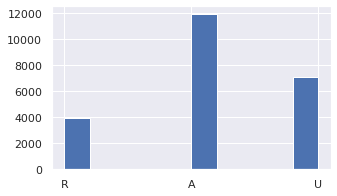

In [ ]:
# Observamos histograma en base a resultado
plt.figure(figsize=(5, 3))
plt.hist(df['resultado'])
plt.show()

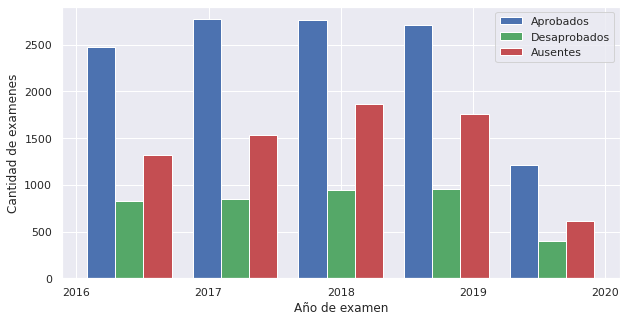

In [ ]:
df['anio_examen'] = pd.DatetimeIndex(df['fecha_examen']).year

# obtengo años de examen de alumnos aprobados
df_aprobados = df[df['resultado'] == 'A']

# obtengo años de examen de alumnos desap
df_desaprobados = df[df['resultado'] == 'R']

# obtengo años de examen de alumnos ausentes
df_ausentes = df[df['resultado'] == 'U']

plt.figure(figsize=(10, 5))
plt.style.use('seaborn-deep')
bins = 5
plt.hist([df_aprobados['anio_examen'], df_desaprobados['anio_examen'], df_ausentes['anio_examen']], bins, label=['Aprobados', 'Desaprobados', 'Ausentes'])
plt.legend(loc='upper right')
plt.xticks([2016,2017,2018,2019,2020])
plt.xlabel('Año de examen')
plt.ylabel('Cantidad de examenes')

plt.show()

In [ ]:
# creo dummies para sexo, para futuros calculos
df['sexo_is_f'] = pd.get_dummies(df["sexo"], drop_first=True)

In [ ]:
# Convierto la nota del tipo Serie a Numerico para obtener el promedio
# Creo DF con solo notas 1 al 10, sin ausentes
# Agrego dummie de resultado A y R
df_sin_ausentes = df[df['nota'] != -1]
df_sin_ausentes['nota'] = pd.to_numeric(df_sin_ausentes['nota'])
df_sin_ausentes['resultado_is_a'] = pd.get_dummies(df_sin_ausentes["resultado"], drop_first=True)

df_sin_ausentes.groupby(['sexo', 'resultado'])['nota'].mean()

sexo  resultado
F     A            6.740549
      R            2.266036
M     A            6.896747
      R            2.162000
Name: nota, dtype: float64

In [ ]:
df_sin_ausentes['nota'].describe()

count    15890.000000
mean         5.646130
std          2.502779
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         10.000000
Name: nota, dtype: float64

No handles with labels found to put in legend.


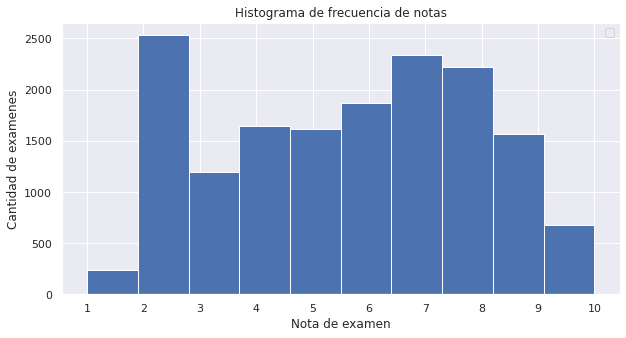

In [ ]:
# Histograma de notas
plt.figure(figsize=(10, 5))
bins=10
plt.style.use('seaborn-deep')
plt.hist(df_sin_ausentes['nota'], bins)
plt.legend(loc='upper right')
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.xlabel('Nota de examen')
plt.title("Histograma de frecuencia de notas")
plt.ylabel('Cantidad de examenes')
plt.show()

In [ ]:
# examenes promedio rendido por año
df_cant_anio = df.groupby(['cod_persona', 'anio_examen']).size().to_frame('cantidad_anio')
df_cant_anio.groupby(['anio_examen'])['cantidad_anio'].mean()

anio_examen
2016    3.838040
2017    3.916350
2018    3.998563
2019    3.546466
2020    2.040330
Name: cantidad_anio, dtype: float64

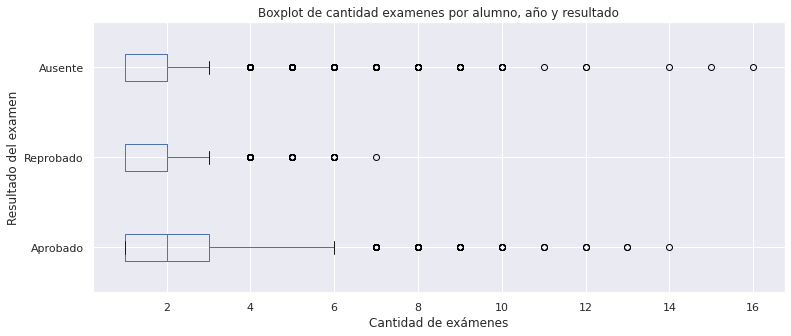

In [ ]:
# obtener boxplot de cantidad examenes segun resultado por año y añumno
df_resultado_count = df.groupby(['cod_persona', 'anio_examen','resultado'])['resultado'].size().to_frame('size')

df_resultado_count.boxplot(by=['resultado'], vert=False, column=['size'], figsize=(12,5))
plt.title("Boxplot de cantidad examenes por alumno, año y resultado")
plt.yticks([1,2,3], ['Aprobado', 'Reprobado', 'Ausente'])
plt.xlabel('Cantidad de exámenes')
plt.ylabel('Resultado del examen')

plt.suptitle('')
plt.show()

## Variable Sexo

In [ ]:
# Observamos de la distribución de la variable sexo, la mayoría de alumnos en la Facultad son mujeres
df.groupby(['sexo_is_f']).size()

sexo_is_f
0    17590
1     5392
dtype: int64

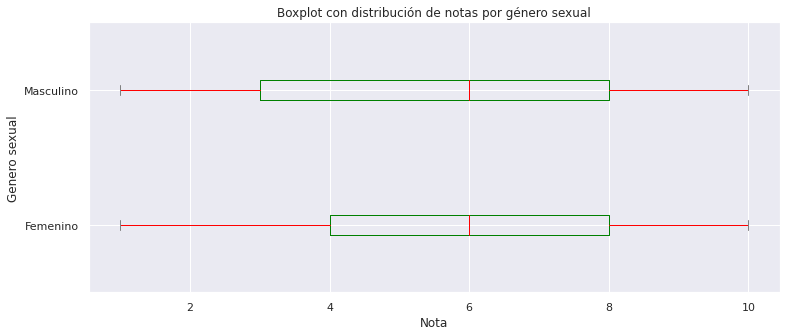

In [ ]:
color = {
    "boxes": "green",
    "whiskers": "red",
    "medians": "red",
    "caps": "gray",
}
df_sin_ausentes.boxplot(by=['sexo'], vert=False, column=['nota'], color = color, figsize=(12,5))
plt.title("Boxplot con distribución de notas por género sexual")
plt.yticks([1,2], ['Femenino', 'Masculino'])
plt.xlabel('Nota')
plt.ylabel('Genero sexual')

plt.suptitle('')
plt.show()

In [ ]:
df_sin_ausentes.groupby(['sexo'])['nota'].mean()

sexo
F    5.641768
M    5.659875
Name: nota, dtype: float64

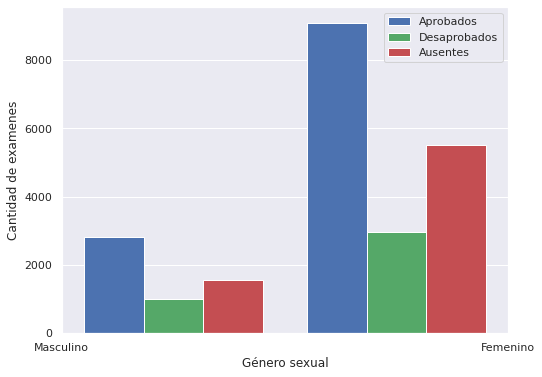

In [ ]:
# obtengo sexo de alumnos aprobados
df_aprobados = df[df['resultado'] == 'A']
# obtengo sexo de alumnos desap
df_desaprobados = df[df['resultado'] == 'R']

# obtengo sexo de alumnos ausentes
df_ausentes = df[df['resultado'] == 'U']

plt.figure(figsize=(8, 6))
plt.style.use('seaborn-deep')
bins = 2
plt.hist([df_aprobados['sexo'], df_desaprobados['sexo'], df_ausentes['sexo']], bins, label=['Aprobados', 'Desaprobados', 'Ausentes'])
plt.legend(loc='upper right')
plt.xticks([0,1],['Masculino', 'Femenino'])
plt.xlabel('Género sexual')
plt.ylabel('Cantidad de examenes')

plt.show()

##Variable de interes: año de nacimiento y edad

In [ ]:
from dateutil.relativedelta import relativedelta

# funcion que obtiene edad de fecha nacimiento
def get_age(end):
    r = relativedelta(pd.to_datetime('now'), end) 
    return r.years

df['fecha_nacimiento'] = pd.to_datetime(df['fecha_nacimiento'])
df['anio_nacimiento'] = df['fecha_nacimiento'].dt.year
df['edad'] = df['fecha_nacimiento'].apply(get_age)


In [ ]:
df['edad'].describe() 

count    22982.000000
mean        29.454007
std          6.879561
min         19.000000
25%         25.000000
50%         28.000000
75%         32.000000
max         73.000000
Name: edad, dtype: float64

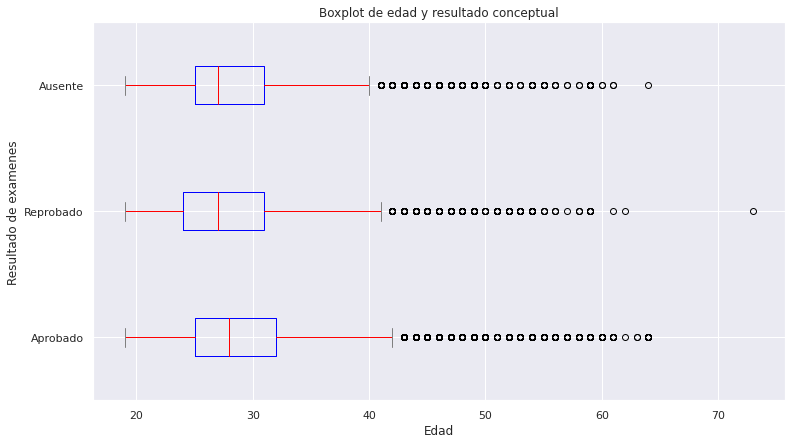

In [ ]:
color = {
    "boxes": "blue",
    "whiskers": "red",
    "medians": "red",
    "caps": "gray",
}
df.boxplot(by=['resultado'], column=['edad'],vert=False, color = color, figsize=(12,7))
plt.suptitle('')
plt.title("Boxplot de edad y resultado conceptual")
plt.yticks([1,2,3], ['Aprobado', 'Reprobado', 'Ausente'])
plt.xlabel('Edad')
plt.ylabel('Resultado de examenes')

plt.show()

In [ ]:
df.groupby(['edad'])['resultado'].count()

edad
19       5
20      72
21     474
22     985
23    1669
24    1949
25    2284
26    2211
27    1597
28    1379
29    1557
30    1438
31    1395
32    1018
33     609
34     646
35     361
36     499
37     294
38     226
39     268
40     179
41     119
42     170
43     236
44     143
45     181
46     174
47     154
48      68
49     159
50      66
51      22
52      69
53      34
54      90
55      24
56      26
57      27
58      23
59      42
60      13
61      10
62       2
63       2
64      12
73       1
Name: resultado, dtype: int64

In [ ]:
#df_sin_ausentes.groupby(['edad'])['nota'].mean().to_frame().T
bins=[0,20,30,40,50,60]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60']
binned_values = np.histogram(df_sin_ausentes['edad'], bins=bins)[0].tolist() # use [0] to just get the counts
df_hist = pd.DataFrame.from_dict(dict(zip(labels, binned_values)), orient='index').reset_index()
df_hist.columns = ['rango_edad', 'cantidad_examenes']
df_hist

,rango_edad,cantidad_examenes
0,0-20,4
1,21-30,9700
2,31-40,4561
3,41-50,1227
4,51-60,374


##Correlación de variables
La matriz de correlación es una importante métrica que se calcula para resumir los datos a fin de comprender la relación entre las diversas variables. En este caso lo vamos a analizar para reducir la dimensionalidad del dataframe.

Cada celda de la matriz de correlación es un “coeficiente de correlación” entre las dos variables correspondientes a la fila y la columna de la celda, y este nos indica cómo es la fuerza de la relación entre dos variables.

In [ ]:
# obtenemos la edad del df
df_sin_ausentes['edad']=df['edad']
# primero pasamos a dummie el valor de resultado para tener variables numéricas
df_sin_ausentes['resultado_is_a'] = pd.get_dummies(df_sin_ausentes["resultado"], drop_first=True)
df_sin_ausentes.groupby(['resultado_is_a']).size()

resultado_is_a
0    11928
1     3962
dtype: int64

In [ ]:
# Obtenemos un dataset de prueba con los examenes sin ausentes, 
# solo nos quedamos con los atributos: edad, sexo,año examen y nota
df_correlacion = df_sin_ausentes[['nota', 'anio_examen', 'sexo_is_f', 'edad', 'resultado_is_a']]

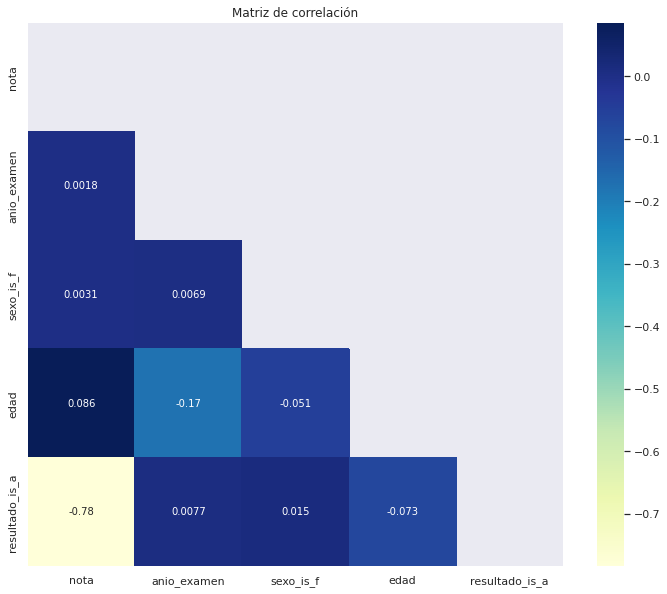

In [ ]:
corr= df_correlacion.corr()
# Obtengo el triangulo de correlación
matrix = np.triu(corr)
plt.figure(figsize = (12,10))
plt.title("Matriz de correlación")

sns.heatmap(corr, mask=matrix,annot=True, cmap="YlGnBu")

consideramos:


*   edad - anio_examen
*   edad - nota



In [ ]:
df_sin_ausentes.groupby(['anio_examen'])['edad'].mean()

anio_examen
2016    31.948500
2017    30.320885
2018    28.949743
2019    28.345345
2020    28.506832
Name: edad, dtype: float64

#Regresion lineal
Primer caso: anio de examen y edad

Segundo caso: nota y edad


Linear Regression:
Slope = -0.030957413712722707   
Intercept = 2018.709631329615 
Coef of determination (R2) = 0.030566955883338583 
Pearson corr coefficient (R) = -0.1748340810120801 
P-value = 2.854067271895435e-109 
Standard error  = 0.0013831295818474243


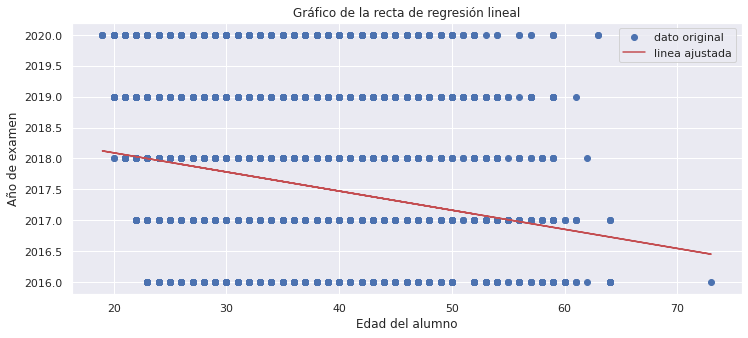

In [ ]:
from scipy import stats

x = df_sin_ausentes['edad'].to_numpy() #variable independiente
y = df_sin_ausentes['anio_examen'].to_numpy() #variable predictora

r = stats.linregress(x, y)
print("Linear Regression:\nSlope = {} \
  \nIntercept = {} \nCoef of determination (R2) = {} \nPearson corr coefficient (R) = {} \nP-value = {} \nStandard error  = {}".format(r.slope, r.intercept, r.rvalue**2,r.rvalue, r.pvalue, r.stderr))

plt.figure(figsize=(12, 5))
plt.plot(x, y, 'o', label='dato original')
plt.plot(x, r.intercept + r.slope*x, 'r', label='linea ajustada')
plt.title('Gráfico de la recta de regresión lineal')
plt.xlabel('Edad del alumno')
plt.ylabel('Año de examen')
  
plt.legend()
plt.show()

Linear Regression:
Slope = 0.02963005935305271   
Intercept = 4.766103825608578 
Coef of determination (R2) = 0.007377678626775618 
Pearson corr coefficient (R) = 0.08589341433879327 
P-value = 2.071222424724184e-27 
Standard error  = 0.0027266541649820703


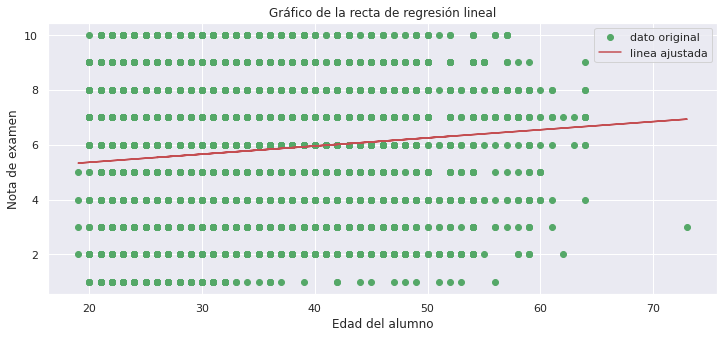

In [ ]:
from scipy import stats

x = df_sin_ausentes['edad'].to_numpy() #variable independiente
y = df_sin_ausentes['nota'].to_numpy() #variable predictora

r = stats.linregress(x, y)
print("Linear Regression:\nSlope = {} \
  \nIntercept = {} \nCoef of determination (R2) = {} \nPearson corr coefficient (R) = {} \nP-value = {} \nStandard error  = {}".format(r.slope, r.intercept, r.rvalue**2,r.rvalue, r.pvalue, r.stderr))

plt.figure(figsize=(12, 5))
plt.plot(x, y, 'o', label='dato original', color="g")
plt.plot(x, r.intercept + r.slope*x, 'r', label='linea ajustada')
plt.title('Gráfico de la recta de regresión lineal')
plt.xlabel('Edad del alumno')
plt.ylabel('Nota de examen')
  
plt.legend()
plt.show()